In [1]:
import pymc as pm
import matplotlib.pyplot as plt
import arviz as az
import xarray as xr
import pandas as pd
from scipy import special, stats
import numpy as np
import seaborn as sns

np.random.seed(42)

In [2]:
penguins = pd.read_csv("data/penguins.csv")
# удалим пропущенные данные
penguins = penguins.dropna(axis=0)

adelie_mask = penguins["species"] == "Adelie"
adelie_mass_obs = penguins.loc[adelie_mask, "body_mass_g"].values
adelie_flipper_length_obs = penguins.loc[adelie_mask, "flipper_length_mm"].values

penguins.tail()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
339,Chinstrap,Dream,55.8,19.8,207.0,4000.0,male,2009
340,Chinstrap,Dream,43.5,18.1,202.0,3400.0,female,2009
341,Chinstrap,Dream,49.6,18.2,193.0,3775.0,male,2009
342,Chinstrap,Dream,50.8,19.0,210.0,4100.0,male,2009
343,Chinstrap,Dream,50.2,18.7,198.0,3775.0,female,2009


## Множественная линейная регрессия

У многих видов существует диморфизм, или различие, между разными полами. Изучение полового диморфизма у пингвинов фактически стало мотивирующим фактором для сбора данных о пингвинах в данном датасете. Чтобы более подробно изучить диморфизм пингвинов, давайте добавим вторуюобъясняющею переменную, связанную с полом, закодируем ее как категориальную переменную и посмотрим, сможем ли мы более точно оценить массу пингвинов.

In [4]:
# Binary encoding of the categorical predictor
sex_obs = penguins.loc[adelie_mask ,"sex"].map({"male":0, "female":1})

with pm.Model() as model_adelie_flipper_sex_regression:
    σ = pm.HalfStudentT("σ", 100, 2000)
    β_0 = pm.Normal("β_0", 0, 3000)
    β_1 = pm.Normal("β_1", 0, 3000)
    β_2 = pm.Normal("β_2", 0, 3000)

    μ = pm.Deterministic(
        "μ", β_0 + β_1 * adelie_flipper_length_obs + β_2 * sex_obs)

    mass = pm.Normal("mass", mu=μ, sigma=σ, observed=adelie_mass_obs)

    idata_adelie_flipper_sex_regression = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β_0, β_1, β_2]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.


Итак добавим новый новый параметр $\beta_2$ влияющий на значение
параметра $\mu$. Поскольку пол является категориальной объясняющей переменной (в данном примере только женский или мужской), мы кодируем его как 1 и 0 соответственно. Для модели это означает, что значение
для самок представляет собой сумму из трех слагаемых, в то время как для самцов - сумму из двух слагаемых (поскольку третье слагаемое будет равно нулю).

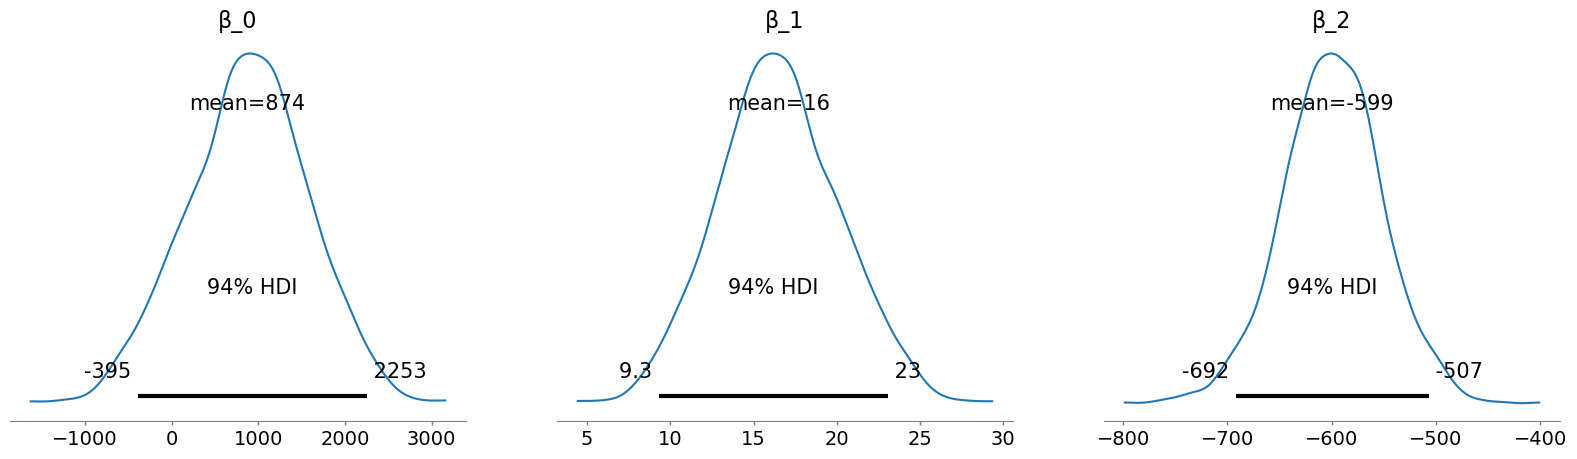

In [6]:
az.plot_posterior(idata_adelie_flipper_sex_regression, var_names =["β_0", "β_1", "β_2"], figsize=(20, 5));

In [7]:
az.summary(idata_adelie_flipper_sex_regression, var_names=["β_0","β_1","β_2", "σ"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
β_0,874.485,702.755,-394.641,2252.813,16.126,11.604,1902.0,2215.0,1.0
β_1,16.474,3.645,9.324,23.052,0.084,0.059,1908.0,2216.0,1.0
β_2,-599.369,48.244,-691.575,-506.883,0.980,0.697,2440.0,2179.0,1.0
σ,274.009,14.066,248.152,300.671,0.286,0.202,2396.0,1662.0,1.0


Поскольку мы закодировали самца как 0, это значение, заданное из `model_adelie_flipper_sex_regression`, оценивает разницу в весе по сравнению с самкой пингвина Адели с такой же длиной плавников.   
Эта последняя часть довольно важна, поскольку, добавляя вторую объясняющею переменную, мы получаем множественную линейную регрессию, и мы должны проявлять еще большую осторожность при интерпретации коэффициентов.   
В этом случае коэффициенты обеспечивают связь объясняющих переменных с зависимой переменной, если все остальные объясняющие переменные остаются постоянными.

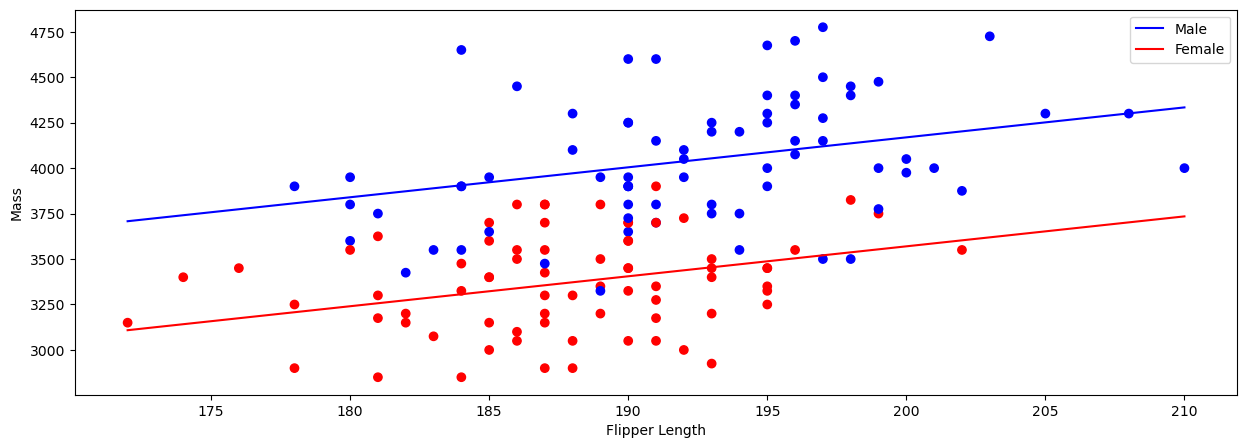

In [9]:
fig, ax = plt.subplots(figsize=(15, 5))
alpha_1 = idata_adelie_flipper_sex_regression.posterior["β_0"].mean().item()
beta_1 = idata_adelie_flipper_sex_regression.posterior["β_1"].mean().item()
beta_2 = idata_adelie_flipper_sex_regression.posterior["β_2"].mean().item()


flipper_length = np.linspace(adelie_flipper_length_obs.min(), adelie_flipper_length_obs.max(), 100)

mass_mean_male = alpha_1 + beta_1 * flipper_length
mass_mean_female = alpha_1 + beta_1 * flipper_length + beta_2

ax.plot(flipper_length, mass_mean_male, label="Male", c='b')
ax.plot(flipper_length, mass_mean_female, c='r', label="Female")
ax.scatter(adelie_flipper_length_obs, adelie_mass_obs, c=[{0:"b", 1:"r"}[code] for code in sex_obs.values])

# # построим интервалы?

ax.set_xlabel('Flipper Length')
ax.set_ylabel('Mass');
ax.legend();

Мы снова можем сравнить стандартные отклонения по нашим трем моделям, чтобы увидеть, уменьшили ли мы неопределенность в нашей оценке, и еще раз дополнительная информация помогла улучшить оценку.  

In [11]:
import pickle
with open('idata_adelie_mass.pkl', 'rb') as f:
    idata_adelie_mass = pickle.load(f)
with open('idata_adelie_flipper_regression.pkl', 'rb') as f:
    idata_adelie_flipper_regression = pickle.load(f)   

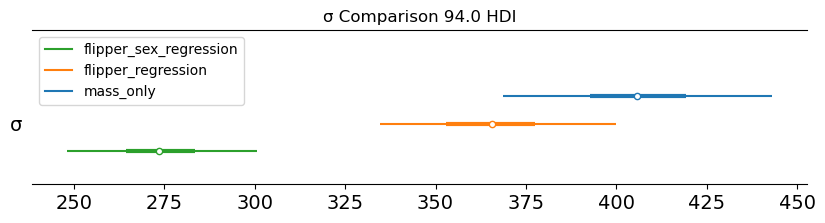

In [12]:
axes = az.plot_forest(
    [idata_adelie_mass, idata_adelie_flipper_regression, idata_adelie_flipper_sex_regression],
    model_names=["mass_only", "flipper_regression", "flipper_sex_regression"],
    var_names=["σ"], combined=True, figsize=(10, 2))

axes[0].set_title("σ Comparison 94.0 HDI");

В данном случае наша новая оценка снизила в 
среднее значение 
с 406 граммов в нашей модели без объясняющей переменной, определенной в `adelie_mass`, до среднего значения 273 граммов из линейной модели `adelie_flipper_sex`, которая включает длину плавника и пол в качестве объясняющей переменной. 
Это снижение неопределенности говорит о том, что пол действительно предоставляет информацию для более точной оценки веса пингвина.

Давайте добавим длинну клюва пингвина в нашу модель и 
попробуем еще уточнить нашу модель.

In [ ]:

adelie_bill_length_obs = penguins.loc[adelie_mask, "bill_length_mm"]
sex_obs = penguins.loc[adelie_mask ,"sex"].map({"male":0, "female":1})


with pm.Model() as model_adelie_flipper_sex_bill_regression:
    
    σ = pm.HalfStudentT("σ", 100, 2000)
    β_0 = pm.Normal("β_0", 0, 3000)
    β_1 = pm.Normal("β_1", 0, 3000)
    β_2 = pm.Normal("β_2", 0, 3000)
    β_3 = pm.Normal("β_3", 0, 3000)
    μ = pm.Deterministic("μ", β_0 + β_1 * adelie_flipper_length_obs + 
                         β_2 * sex_obs + β_3 * adelie_bill_length_obs )

    mass = pm.Normal("mass", mu=μ, sigma=σ, observed=adelie_mass_obs)

    idata_adelie_flipper_sex_bill_regression = pm.sample()
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β_0, β_1, β_2, β_3]


Output()

In [ ]:
axes = az.plot_forest(
    [idata_adelie_mass, idata_adelie_flipper_regression, 
     idata_adelie_flipper_sex_regression, idata_adelie_flipper_sex_bill_regression],
    model_names=["mass_only", "flipper_regression", "flipper_sex_regression", "flipper_sex_bill_regression"],
    var_names=["σ"], combined=True, figsize=(10, 2))

axes[0].set_title("σ Comparison 94.0 HDI");

Посмотрите результат моделирования. Какие выводы можно сделать?




Ранее мы сделали прогноз, 
используя параметры, установленные в модели с одной объясняющей переменной и нашей целевой переменной. Теперь возьмем новую модель, где меняя длину плавника, получить оценку веса пингвина в зависимости  от фиксированной длине клюва и пола. 

В случае множественной регрессии мы можем, взяв нашу регрессию, сохранив постоянными все объясняющие переменные, кроме одной, и посмотрев, как изменение этой одной объясняющей переменной изменит наш ожидаемый результат. 

Этот анализ называется counterfactual analysis (контрфактуальным анализом). Давайте расширим множественную регрессию из предыдущего раздела, на этот раз включив длину клюва, и проведем контрфактуальный анализ. 

Внимательно посмотрите как изменился код, чтобы мы могли произвести дальнейший расчет на произвольной сетке параметров.

In [ ]:
with pm.Model() as model:
    adelie_flipper_length =pm.Data("adelie_flipper_length", adelie_flipper_length_obs)
    sex = pm.Data("sex", sex_obs.astype('int32'))
    adelie_bill_length = pm.Data("adelie_bill_length", adelie_bill_length_obs)
    
    σ = pm.HalfStudentT("σ", 100, 2000)
    β_0 = pm.Normal("β_0", 0, 3000)
    β_1 = pm.Normal("β_1", 0, 3000)
    β_2 = pm.Normal("β_2", 0, 3000)
    β_3 = pm.Normal("β_3", 0, 3000)
    
    μ = pm.Deterministic("μ", β_0 + β_1 * adelie_flipper_length + β_2 * sex
                           + β_3 * adelie_bill_length )

    mass = pm.Normal("mass", mu=μ, sigma=σ, observed=adelie_mass_obs, shape=μ.shape)

    idata = pm.sample()

Посмотрите гиже код и ответьте на следующие вопросос: капие параметры мы зависиксировали в нашей "воображаемой" модели?

In [ ]:
counterfactual_flipper_lengths = np.linspace(150,240,200)
with model:
    pm.set_data(
        {
            "adelie_flipper_length": counterfactual_flipper_lengths,
            "sex": (np.zeros_like(counterfactual_flipper_lengths)).astype('int32'),
            "adelie_bill_length": np.ones_like(counterfactual_flipper_lengths)*
                (adelie_bill_length_obs.mean())       
        }
    )
    counterfactual = pm.sample_posterior_predictive(
        idata,
        predictions=True,
        var_names=["mass", "μ"]
    )

_, ax = plt.subplots(figsize=(15, 5))
az.plot_hdi(counterfactual_flipper_lengths, counterfactual.predictions["mass"], 
            hdi_prob=0.94, smooth=False, ax=ax)
ax.plot(counterfactual_flipper_lengths,
        counterfactual.predictions["mass"].mean(("chain", "draw")));


Данный график называется контрфактическим графиком. Как следует из слова "контрфактический", мы оцениваем ситуацию, противоречащую наблюдаемым данным или фактам. Другими словами, мы оцениваем ситуации, которые не произошли. Простейшее использование контрафактического графика - это корректировка объясняющей переменной и изучение результата, точно так же, как мы только что сделали. 

Это позволяет нам исследовать сценарии "что, если", которые в противном случае были бы нам недоступны. 

Однако мы должны быть осторожны при интерпретации этого обмана. 

Первая ловушка заключается в том, что могут оказаться невозможными контрфактические значения, например, возможно, никогда не существовало пингвинов с длиной плавников более 1500 мм, но модель с радостью даст нам оценки для этого вымышленного пингвина. 

Второй вариант более коварен, мы предполагали, что можем варьировать каждую объясняющею переменную независимо, но на самом деле это может оказаться невозможным. 

Например, с увеличением длины плавников у пингвина может увеличиваться и длина его клюва. 

Контрфактуализм полезен тем, что позволяет нам исследовать результаты, которые еще не произошли или, по крайней мере, мы не наблюдали, как они происходили, но они могут легко генерировать оценки для ситуаций, которые никогда не произойдут. Это модель, которая не будет отличать одно от другого, поэтому вы, как разработчик моделей, должны это сделать.